In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

/home/jason/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# images in one batch
batch_size = 4

tr = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trloader = torch.utils.data.DataLoader(tr, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

te = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
teloader = torch.utils.data.DataLoader(te, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


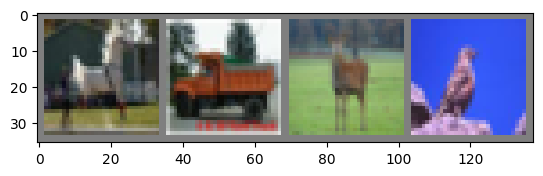

horse      truck      deer       bird      


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:10s}' for j in range(batch_size)))


In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # convolution 
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


---
### Inner workings of the CNN
The input of a convolutional layer is a $m\times m \times r$ source image where $m$ is the height and width and $r$ is the number of channels. 
eg: for RGB colorspace, $r=3$ and each channel has a corresponding $m \times m$ image. 

The layer will have $k$ output channels corresponding to $k$ convolution kernels of size $n\times n \times q$ where $n$ is the kernel size and $q \leq r$.
Thus, the $k$ output channels will store the convolutions of the source image by their respective kernels. The size of the convolved image is, with a stride of $1$, $(m-n+1)\times(m-n+1)$.
So if the input is $32\times 32 \times 3$ and there are $6$ kernels of size $5\times 5$ in the layer, then the output of the layer will be $6$ channels of $28 \times 28$, or $6 \times 28 \times 28$. In other words, the layer will output $6$ different $28 \times 28$.

Note: it's usually assumed that the filter (kernel) cannot go beyond the boundary of the image

**Pooling** layers are intermediate layers that reduce the number of features outputted by a convolutional layer.
`MaxPool2d(k, s)` convolves through an image with a kernel of size $k$ and a stride of $s$ and chooses the maximum value within the window. So `MaxPool(2, 2)` essentially cuts the number of features outputted in half. 

The **Activation function** of choice here is ReLU which is used in the convolution layers as well as the dense layers. To predict class labels we will use the *softmax* function on the output layer (or sigmoid for binary classification).

In the convolutional and hidden layers, the purpose of the activation function is to introduces non-linearity, enabling the network to learn nonlinear features.

In [5]:
dataiter = iter(teloader)
images, labels = next(dataiter)

conv1 = nn.Conv2d(3, 6, 5)
# the second layer maps the 6 
conv2 = nn.Conv2d(6, 16, 5)
# pool layer compresses the data from the convolutional layers
pool = nn.MaxPool2d(2, 2)
x1 = F.relu(conv1(images))
x2 = pool(F.relu(conv1(images)))
x3 = pool(F.relu(conv2(x2)))
# flatten dimension 1 onwards into a single dimension (dimension 0 is corresponds to the number of images)
x4 = torch.flatten(x3, 1)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)

torch.Size([4, 6, 28, 28])
torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 5, 5])
torch.Size([4, 400])


---

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.193
[1,  4000] loss: 1.828
[1,  6000] loss: 1.657
[1,  8000] loss: 1.563
[1, 10000] loss: 1.487
[1, 12000] loss: 1.431
[2,  2000] loss: 1.378
[2,  4000] loss: 1.348
[2,  6000] loss: 1.327
[2,  8000] loss: 1.293
[2, 10000] loss: 1.298
[2, 12000] loss: 1.261
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

---
### Testing

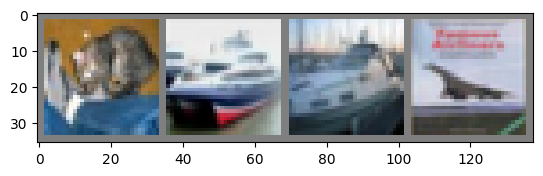

GroundTruth:  cat   ship  ship  plane


In [9]:
dataiter = iter(teloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
outputs = net(images)
print(outputs.shape)

_, predicted = torch.max(outputs, dim=1)
print(predicted.shape)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:10s}'
                              for j in range(batch_size)))

# examine the probabilities of the first image. 
print(F.softmax(outputs[0], dim=-1))
print(outputs[0].exp() / outputs[0].exp().sum())


torch.Size([4, 10])
torch.Size([4])
Predicted:  cat        ship       plane      plane     
tensor([4.2943e-04, 3.7414e-04, 1.2793e-02, 8.0021e-01, 4.9041e-03, 1.0896e-01,
        6.8717e-02, 2.9208e-03, 4.4356e-04, 2.4168e-04],
       grad_fn=<SoftmaxBackward0>)
tensor([4.2943e-04, 3.7414e-04, 1.2793e-02, 8.0021e-01, 4.9041e-03, 1.0896e-01,
        6.8717e-02, 2.9208e-03, 4.4356e-04, 2.4168e-04],
       grad_fn=<DivBackward0>)


In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in teloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 52 %


In [13]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in teloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 68.0 %
Accuracy for class: car   is 52.2 %
Accuracy for class: bird  is 32.4 %
Accuracy for class: cat   is 62.0 %
Accuracy for class: deer  is 20.0 %
Accuracy for class: dog   is 21.7 %
Accuracy for class: frog  is 81.2 %
Accuracy for class: horse is 65.2 %
Accuracy for class: ship  is 64.8 %
Accuracy for class: truck is 56.7 %


In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
if device != 'cpu':
    net.to(device)
    inputs, labels = data[0].to(device), data[1].to(device)

cpu
